# Projet : Analyse de la personnalité des consommateurs avec Data Mining

**Objectif du projet :**  
Utiliser les données des campagnes marketing des consommateurs pour découvrir des **patrons de consommation** en utilisant le clustering **K-means**.

**Étapes principales :**
- Connexion aux données via MongoDB.
- Nettoyage des données et gestion des valeurs manquantes.
- Analyse exploratoire des données.
- Clustering des consommateurs en groupes significatifs.


In [8]:
from pymongo import MongoClient
import pandas as pd

# Connexion à MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['Data_Mining_K']
collection = db['customers']

# Chargement des données dans un DataFrame Pandas
data = pd.DataFrame(list(collection.find()))

# Affichage des 5 premières lignes
print("Aperçu des données :")
print(data.head())


Aperçu des données :
                        _id    ID  Year_Birth   Education Marital_Status  \
0  679e62405282849867f5e304  5524        1957  Graduation         Single   
1  679e62405282849867f5e305  2174        1954  Graduation         Single   
2  679e62405282849867f5e306  4141        1965  Graduation       Together   
3  679e62405282849867f5e307  6182        1984  Graduation       Together   
4  679e62405282849867f5e308  5324        1981         PhD        Married   

    Income  Kidhome  Teenhome Dt_Customer  Recency  ...  NumWebVisitsMonth  \
0  58138.0        0         0  2012-09-04       58  ...                  7   
1  46344.0        1         1  2014-03-08       38  ...                  5   
2  71613.0        0         0  2013-08-21       26  ...                  4   
3  26646.0        1         0  2014-02-10       26  ...                  6   
4  58293.0        1         0  2014-01-19       94  ...                  5   

   AcceptedCmp3  AcceptedCmp4  AcceptedCmp5  Accepted

In [9]:
from datetime import datetime

data = data.copy()
# Conversion de l'année de naissance en âge
current_year = datetime.now().year
data['Age'] = current_year - data['Year_Birth']

# Remplissage des valeurs manquantes pour les colonnes numériques
numeric_cols = data.select_dtypes(include=['number']).columns
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].median())

# Suppression des valeurs invalides d'âge (ex : âge négatif ou trop élevé)
data = data[(data['Age'] > 0) & (data['Age'] < 100)].copy()


print("Données après nettoyage :")
print(data[['Age', 'Income', 'Kidhome', 'Teenhome']].head())


Données après nettoyage :
   Age   Income  Kidhome  Teenhome
0   68  58138.0        0         0
1   71  46344.0        1         1
2   60  71613.0        0         0
3   41  26646.0        1         0
4   44  58293.0        1         0


In [10]:
# Statistiques descriptives de base
print(data.describe())

# Analyse des valeurs manquantes
print("Valeurs manquantes :")
print(data.isnull().sum())


                 ID   Year_Birth         Income      Kidhome     Teenhome  \
count   2237.000000  2237.000000    2237.000000  2237.000000  2237.000000   
mean    5590.726419  1968.901654   52227.407689     0.444345     0.506482   
min        0.000000  1940.000000    1730.000000     0.000000     0.000000   
25%     2829.000000  1959.000000   35523.000000     0.000000     0.000000   
50%     5455.000000  1970.000000   51381.500000     0.000000     0.000000   
75%     8427.000000  1977.000000   68281.000000     1.000000     1.000000   
max    11191.000000  1996.000000  666666.000000     2.000000     2.000000   
std     3245.118591    11.701917   25043.266830     0.538467     0.544593   

                         Dt_Customer      Recency     MntWines    MntFruits  \
count                           2237  2237.000000  2237.000000  2237.000000   
mean   2013-07-10 05:01:54.260169728    49.104604   303.995530    26.270451   
min              2012-07-30 00:00:00     0.000000     0.000000     0.

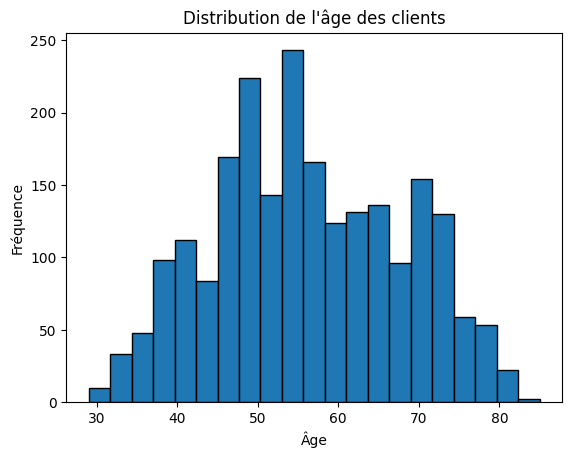

In [11]:
import matplotlib.pyplot as plt

# Histogramme de la distribution de l'âge
plt.hist(data['Age'], bins='auto', edgecolor='black')
plt.title('Distribution de l\'âge des clients')
plt.xlabel('Âge')
plt.ylabel('Fréquence')
plt.show()


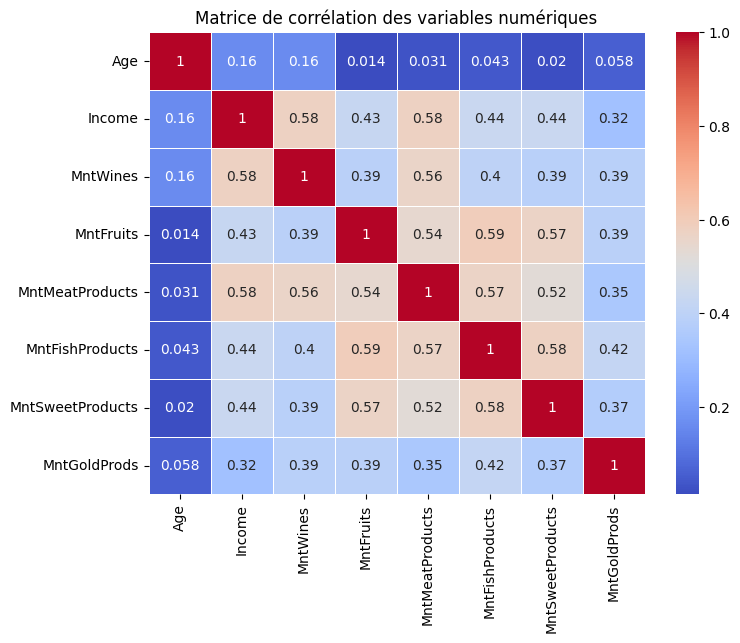

In [12]:
import seaborn as sns

# Sélection des colonnes numériques pour la corrélation
numerical_cols = ['Age', 'Income', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']

# Calcul de la matrice de corrélation
corr_matrix = data[numerical_cols].corr()

# Affichage sous forme de heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matrice de corrélation des variables numériques')
plt.show()


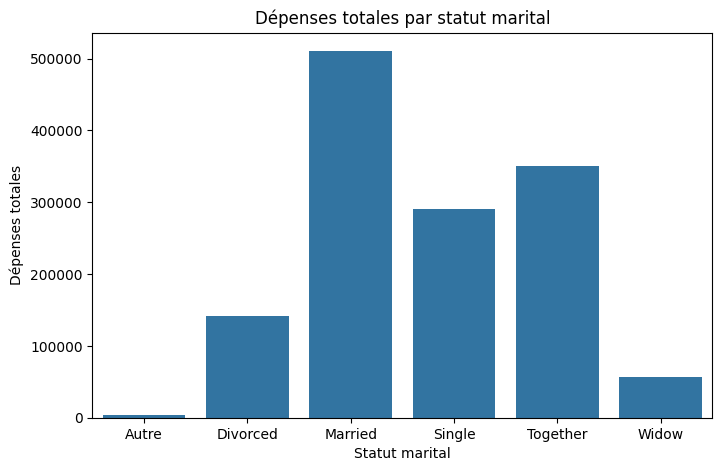

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Supposons que les données sont déjà chargées dans 'data'

# Étape 1 : Calcul de la dépense totale
product_columns = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
data['Total_Spend'] = data[product_columns].sum(axis=1)

# Étape 2 : Nettoyage des catégories maritales inhabituelles
# Grouper les catégories inhabituelles sous "Autre"
data['Marital_Status'] = data['Marital_Status'].replace(['Absurd', 'YOLO', 'Alone'], 'Autre')

# Étape 3 : Agrégation des dépenses totales par statut marital
spend_by_status = data.groupby('Marital_Status')['Total_Spend'].sum().reset_index()

# Étape 4 : Visualisation avec un graphique en barres
plt.figure(figsize=(8, 5))
sns.barplot(data=spend_by_status, x='Marital_Status', y='Total_Spend')
plt.title('Dépenses totales par statut marital')
plt.xlabel('Statut marital')
plt.ylabel('Dépenses totales')
plt.show()


   Total_Spend
0         1617
1           27
2          776
3           53
4          422


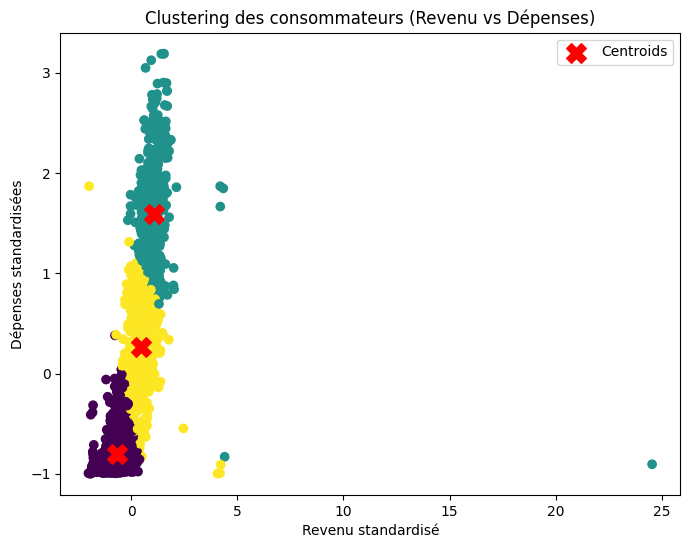

In [14]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Créer la colonne 'Total_Spend' en additionnant dynamiquement les dépenses
data['Total_Spend'] = data[product_columns].sum(axis=1)

# Vérifiez que la colonne a été créée correctement
print(data[['Total_Spend']].head())

# Sélection des colonnes pertinentes pour le clustering
features = data[['Income', 'Total_Spend']]

# Standardisation des données
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Application de K-means avec 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
data['Cluster'] = kmeans.fit_predict(features_scaled)

# Visualisation des clusters
plt.figure(figsize=(8, 6))
plt.scatter(features_scaled[:, 0], features_scaled[:, 1], c=data['Cluster'], cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Centroids')
plt.title('Clustering des consommateurs (Revenu vs Dépenses)')
plt.xlabel('Revenu standardisé')
plt.ylabel('Dépenses standardisées')
plt.legend()
plt.show()


## Conclusion :

L'analyse de clustering K-means a permis de regrouper les clients en 3 clusters distincts :
- **Cluster 0** : Clients à revenu moyen et dépenses modérées.
- **Cluster 1** : Clients à faible revenu et faible niveau de dépenses.
- **Cluster 2** : Clients à revenu élevé avec des dépenses importantes.

Cette segmentation pourrait être utilisée pour personnaliser les campagnes marketing et optimiser les efforts de rétention des clients.
